<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación de texto con CNN<a id="top"></a>

<i><small>Última actualización: 2024-03-11</small></i></div>

***

## Introducción

En el procesamiento del lenguaje natural (NLP, del inglés natural language processing), una tarea muy típica es la clasificación de textos. En esta tarea, un texto dado se clasifica según su significado. A menudo se utiliza, por ejemplo, para el problema del análisis de sentimientos.

Se trata de un problema denominado _many-to-one_, es decir, uno en el que el tamaño de la secuencia de entrada es $T_X = 1$, pero el tamaño de la secuencia de salida es $T_Y = 1$.

## Objetivos

Vamos a hacer un experimento en el que utilizaremos el conjunto de datos de reseñas de amazon para una tarea de análisis de sentimiento. A partir de los datos de reseñas y valoraciones, identificaremos si una reseña es positiva, neutra o negativa, y para ello utilizaremos una primera aproximación utilizando un modelo de redes neuronales convolucionales.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import os
import numpy as np
import requests
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from shutil import unpack_archive

import matplotlib.pyplot as plt
from utils import get_device

Using device: mps


In [2]:
device = get_device()
print(f'Using device: {device}')

Using device: mps


También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [3]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Y crearemos los directorios necesarios en caso de que no se hayan creado previamente

In [4]:
os.makedirs('tmp', exist_ok=True)

***

## Parámetros globales

Comenzaremos definiendo los parámetros que utilizaremos a lo largo del cuaderno, que consistirán en la longitud máxima de las secuencias (recuerda que deben tener una longitud fija) y la dimensión del vector de cada palabra.

In [5]:
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 16384
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 32
EPOCHS = 2
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'
GLOVE_PATH = "tmp/glove.6B.300d.txt"

## Preprocesamiento de datos

Vamos a cargar los datos de entrenamiento, que consistirán en los datos de reseñas de Amazon de la categoría «Música digital» (https://nijianmo.github.io/amazon/index.html).

In [6]:
DATASET_URL = 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz'
DATASET_ZIP = 'tmp/Digital_Music_5.json.gz'

# Download the remote file if it does not exist
if not os.path.exists(DATASET_ZIP):
    with open(DATASET_ZIP, 'wb') as f:
        print(f'Downloading {DATASET_ZIP}...')
        r = requests.get(DATASET_URL, verify=False)
        f.write(r.content)
        print('OK')

corpus = pd.read_json(DATASET_ZIP, lines=True)
corpus.dropna(subset=['overall', 'reviewText'], inplace=True)
corpus.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


El proceso que realizaremos en este _notebook_ será ver cómo construir un modelo convolucional para trabajar con este tipo de conjuntos de datos. Por lo tanto no entraremos en el detalle de obtener un conjunto de datos de prueba.

Sin embargo, hay que tener en cuenta que en un problema real sería necesario entrenar con validación y contrastar con un conjunto de prueba antes de poner nuestro modelo en producción.

### Preparando la entrada a nuestro modelo

La entrada de nuestro modelo serán las reseñas como tales; por lo tanto, tomaremos la columna `reviewText` como nuestro conjunto de entrenamiento.

In [7]:
x_train = corpus['reviewText'].astype(str).str.strip()
print(f'Training input shape: {x_train.shape}')

Training input shape: (169623,)


Ahora crearemos una capa [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization), que se encargará de:

1. Convertir una reseña completa en una secuencia de enteros (palabras), asignando a cada palabra un valor único.
2. Truncar o rellenar las sencuencias para que estas mantengan una longitud fija previamente establecida (en nuestro caso `MAX_SEQUENCE_LEN`).

El vocabulario se extraerá de nuestra entrada, tomando las `MAX_VOCAB_SIZE` palabras más comunes. Hemos añadido `+ 2` a la longitud ya que hay dos tokens preasignados: Padding (`''`) y palabras fuera del vocabulario (`'[UNK]'`).

### Preparando la salida de nuestro modelo

Partiendo de la base de que las reseñas con valoraciones altas serán positivas y las que tengan valoraciones bajas serán negativas, conservaremos sólo la reseña y la valoración del producto del conjunto de datos.

En concreto, convertiremos las valoraciones de las reseñas en 0 si son malas (1 o 2 estrellas), 1 si son mediocres (3 estrellas) y 2 si son buenas (4 o más estrellas).

In [8]:
y_train = corpus['overall'].astype(int).replace({
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2,
})
print(f'Training output shape: {y_train.shape}')

Training output shape: (169623,)


In [9]:
print(type(x_train))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## Uso de _embeddings_ preentrenados en nuestro modelo

Ya hemos visto que, a la hora de construir un modelo lingüístico, un aspecto importante es la representación de las palabras. Para captar el significado semántico de las palabras, utilizamos _embeddings_ de palabras, que son representaciones vectoriales de palabras en un espacio donde cada una de las muchas dimensiones representan una característica semántica.

Esta vez, en lugar de entrenar nuestros _embeddings_ desde cero, aprovecharemos uno preentrenado, _Global Vectors for Word Representation_ (GLoVe), entrenado con un conjunto de datos de más de 6.000 millones de tokens. Cuenta con varios vectores de palabras preentrenados, por lo que los utilizaremos en <http://nlp.stanford.edu/data/glove.6B.zip>.

In [10]:
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Unzip in the directory 'glove'.
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, 'tmp')
print('OK')

Unpacking ...OK


Mediante su uso podemos aprovechar la gran cantidad de conocimiento codificado en estos _embeddings_, lo que seguramente mejore (y mucho)el rendimiento de nuestro modelo lingüístico.

Ahora carguemos el _embedding_ de la dimensión especificada en la configuración. El archivo se compone de líneas de tuplas, donde el primer elemento es la palabra (en texto) y el segundo es ese vector de palabras

In [11]:
from torchtext.vocab import build_vocab_from_iterator
import torch
import numpy as np

def yield_tokens(corpus):
    """Iterador que genera listas de tokens a partir del corpus"""
    for text in corpus:
        yield text.split()  # Asume que el corpus ya está tokenizado por espacios

def load_glove_embeddings(glove_path, corpus, embedding_dim, max_vocab_size):
    print("Building vocabulary... ", end="")
    
    # Construimos el vocabulario a partir del corpus
    vocab = build_vocab_from_iterator(yield_tokens(corpus), specials=["<unk>", "<pad>"], max_tokens=max_vocab_size+2)
    vocab.set_default_index(vocab["<unk>"])
    
    print(f"done ({len(vocab)} words).")
    
    print("Loading GloVe embeddings... ", end="")
    word2vec = {}
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word2vec[word] = vector
    
    print("done.")

    print("Creating embedding matrix with GloVe vectors... ", end="")
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    unassigned_words = 0

    for word, idx in vocab.get_stoi().items():
        if idx >= max_vocab_size + 2:
            continue  # Saltar si el índice supera el tamaño máximo del vocabulario

        if word == "<unk>":
            word = "unk"  # Mapear "<unk>" a "unk" para compatibilidad con GloVe

        word_vector = word2vec.get(word)
        if word_vector is not None:
            embedding_matrix[idx] = word_vector
        else:
            unassigned_words += 1

    print(f"Number of words in GloVe: {len(word2vec)}")
    print(f"Done ({unassigned_words} words unassigned).")
    print(f"Vocab length: {len(vocab)}")

    return vocab, torch.tensor(embedding_matrix, dtype=torch.float)


Bueno, $400.000$ _tokens_ son bastantes. Como nuestro vocabulario es menor, vamos a crear una capa de incrustación más pequeña, del tamaño de nuestro vocabulario. Para ello, incluiremos en ésta sólo los vectores de las palabras que nos devolverá la capa `TextVectorization`.

Comenzaremos creando la matriz de incrustación con los vectores del guante

In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_index, max_len):
        self.texts = [[word_index.get(word, 1) for word in text.split()] for text in texts]
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = self.texts[idx]
        x = x[:self.max_len] + [0] * (self.max_len - len(x))  # Padding
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [17]:
texts = x_train.values
labels = y_train.values

word_index = {word: i+2 for i, word in enumerate({word for text in texts for word in text.split()})}
# Make sure that no index exceeds MAX_VOCAB_SIZE
word_index = {word: min(i + 2, MAX_VOCAB_SIZE + 1) for word, i in word_index.items()}

embedding_matrix = load_glove_embeddings(GLOVE_PATH, word_index, EMBEDDING_DIM, MAX_VOCAB_SIZE)[1]      #!!! ojo al [1], devuelve (vocab, embedding_matrix)

Building vocabulary... done (16386 words).
Loading GloVe embeddings... done.
Creating embedding matrix with GloVe vectors... Number of words in GloVe: 400000
Done (16310 words unassigned).
Vocab length: 16386


In [18]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_texts, train_labels, word_index, MAX_SEQUENCE_LENGTH)
val_dataset = TextDataset(val_texts, val_labels, word_index, MAX_SEQUENCE_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Bueno, al parecer hay muchas palabras que no tienen correspondencia en el _embedding_ descargada. Después de todo $400000$ _tokens_ igual no eran tantos después de todo.

Una vez hecho esto, podemos crear una capa de incrustación con la matriz de pesos precargada.

```python
self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
```

In [19]:
class TextCNN(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super(TextCNN, self).__init__()
        # haría un Sequential(), pero no consigo manejar bien la capa embedding :/
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.conv1 = nn.Conv2d(1, 50, (3, EMBEDDING_DIM))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(50, num_classes)

    def forward(self, x):
        # esto, a esto me refiero:
        x = self.embedding(x).unsqueeze(1)  # dimensión de canal
        x1 = torch.relu(self.conv1(x)).squeeze(3)
        x1 = torch.max_pool1d(x1, x1.size(2)).squeeze(2)
        x = self.dropout(x1)
        return self.fc(x)

# training evaluation 
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_loss = total_loss / len(dataloader)
    train_accuracy = correct_predictions / total_samples
    return train_loss, train_accuracy

def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(true_labels, predictions)
    val_report = classification_report(true_labels, predictions, output_dict=True)
    return val_acc, val_report

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextCNN(embedding_matrix, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
print(f"Sample texts: {texts[:3]}")
print(f"Sample word_index: {list(word_index.items())[:10]}")
print(f"Total words in word_index: {len(word_index)}")


Sample texts: ['This is awesome to listen to, A must-have for all Slayer fans..sadly needed to be a triple disc set..They have so many hits!!'
 'bien'
 'It was great to hear the old stuff again and I like the new stuff too. I recommend it to any Slayer fan.']
Sample word_index: [('Toxicity', 4), ('Rubber', 5), ('Town!', 6), ('Life</a>,', 7), ("WILSON'S", 8), ('Alot!', 9), ('Blue,', 10), ('subtleties,', 11), ('decent', 12), ('brillant', 13)]
Total words in word_index: 198816


## Clasificación basada en redes neuronales convolucionales

Haremos una aproximación al problema utilizando redes convolucionales. En este caso, nuestras frases estarán representadas por «imágenes» de una sola fila, con tantas columnas como la longitud de la secuencia especificada y tantos canales como la dimensión de cada valabra de la secuencia.

Entrenemos el modelo y esperemos que salga bien.

In [22]:
history = []
for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_acc, val_report = evaluate_model(model, val_loader, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_report': val_report
    })

100%|██████████| 4241/4241 [01:25<00:00, 49.67it/s]


Epoch 1/2, Train Loss: 0.2711, Train Accuracy: 0.9362, Validation Accuracy: 0.9375


100%|██████████| 4241/4241 [01:24<00:00, 49.95it/s]


Epoch 2/2, Train Loss: 0.2523, Train Accuracy: 0.9371, Validation Accuracy: 0.9378


Echemos un vistazo al progreso del entrenamiento:

In [25]:
history_df = pd.DataFrame(history)
history_df

,epoch,train_loss,train_acc,val_acc,val_report
0,1,0.271052,0.936226,0.937509,"{'0': {'precision': 0.5421686746987951, 'recal..."
1,2,0.252311,0.937081,0.937804,"{'0': {'precision': 0.5378787878787878, 'recal..."


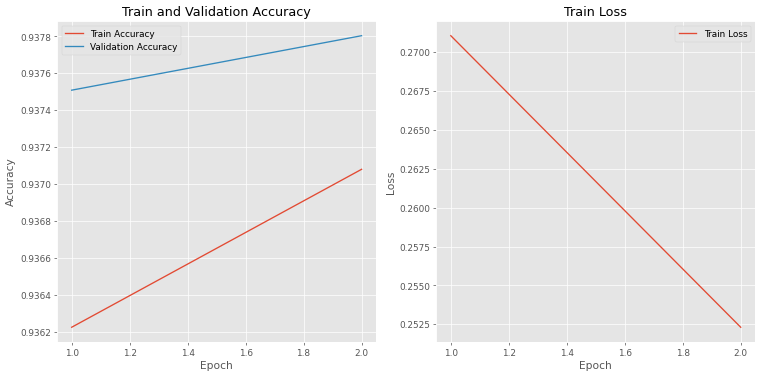

In [27]:
plt.figure(figsize=(12, 6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Accuracy')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.tight_layout()
plt.show()

Veamos ahora cómo interpreta el sentimiento de una reseña buena, regular y mala extraída del sitio web de amazon.

In [28]:
good = "My nephew is on the autism spectrum and likes to fidget with things so I knew this toy would be a hit. Was concerned that it may not be \"complex\" enough for his very advanced brain but he really took to it. Both him (14 yrs) and his little brother (8 yrs) both enjoyed playing with it throughout Christmas morning. I'm always happy when I can find them something unique and engaging."
poor = "I wasn't sure about this as it's really small. I bought it for my 9 year old grandson. I was ready to send it back but my daughter decided it was a good gift so I'm hoping he likes it. Seems expensive for the price though to me."
evil = "I just wanted to follow up to say that I reported this directly to the company and had no response. I have not gotten any response from my review. The level of customer service goes a long way when an item you purchase is defective and this company didn’t care to respond. No I am even more Leary about ordering anything from this company. I never asked for a refund or replacement since I am not able to return it. I’m just wanted to let them know that this was a high dollar item and I expected it to be a quality item. Very disappointed! I bought this for my grandson for Christmas. He loved it and played with it a lot. My daughter called to say that the stickers were peeling on the corners. I am not able to take it from my grandson because he is autistic and wouldn’t understand. I just wanted to warn others who are wanting to get this. Please know that this is a cool toy and it may not happen to yours so it is up to you."

test_texts = [good, poor, evil]
test_labels = [2, 1, 0]  # good, poor, evil
test_dataset = TextDataset(test_texts, test_labels, word_index, MAX_SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
print("\nTest Results:")
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_class = torch.argmax(outputs, dim=1).item()
        print(f"Sample {i + 1} classified as: {predicted_class}")


Test Results:
Sample 1 classified as: 2
Sample 2 classified as: 2
Sample 3 classified as: 0


## Conclusiones

Hemos demostrado cómo utilizar una red neuronal convolucional para clasificar texto, en concreto, reseñas de productos como buenas, medias o malas. También hemos analizado las ventajas de utilizar incrustaciones de palabras preentrenadas, que pueden ayudar a mejorar el rendimiento del modelo aprovechando las relaciones semánticas entre las palabras del corpus preentrenado. También exploramos la capa TextVectorization, que proporciona una forma flexible de preprocesar datos de texto y convertirlos en vectores numéricos.

Se trata de un ejemplo que puede servir de punto de partida para multitud de proyectos de NLP.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>